# Bases de datos NoSQL

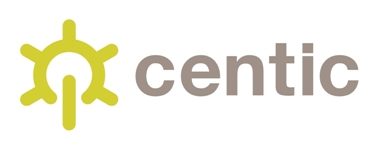


Jesús García Molina, [jmolina@um.es](mailto:jmolina@um.es) y Diego Sevilla Ruiz, [dsevilla@um.es](mailto:dsevilla@um.es).

Esta hoja está disponible en https://github.com/dsevilla/centic18.

In [ ]:
# %load utils/functions.py
from PIL import ImageFont
from PIL import ImageDraw
from PIL import Image as PImage
import math

font = ImageFont.truetype("fonts/OpenSans-ExtraBold.ttf", 150)
#fontEmoji = ImageFont.truetype("fonts/OpenSansEmoji.ttf", 150)
font_small = ImageFont.truetype("fonts/OpenSans-ExtraBold.ttf", 60)

#def sayEmoji(string):
#    return say_(string, fontEmoji)

def say(string):
    return say_(string, font)

yodaimg = PImage.open('images/yoda.jpg')
scale=1.5

def yoda(string):
    return herosay(string, yodaimg)

def herosay(string, img):    
    fontsize = font_small.getsize(string)
    imgcp = img.copy()
    ys = imgcp.size
    imgsize = [int(fontsize[0]*scale), int(fontsize[0] * scale * ys[1] / ys[0])]
    imgcp = imgcp.resize(imgsize)
    draw = ImageDraw.Draw(imgcp)
    draw.text((int(fontsize[0] * (1 - scale/2)),
               int(imgcp.size[1] - fontsize[1]*scale)),
              string,
              (255,255,255,1), 
              font=font_small)
    return imgcp
    
def say_(string, font):
    if len(string) == 0:
        return False
    
    fontsize = font.getsize(string) #The size of the font
    imgsize = [int(fontsize[0] * scale), int(fontsize[1] * scale)]

    image = PImage.new('RGB', imgsize) #Create the image

    innerColor = [80, 80, 255] #Color at the center
    outerColor = [0, 0, 80] #Color at the corners

    for y in range(imgsize[1]):
        for x in range(imgsize[0]):

            #Find the distance to the corner
            distanceToCorner = math.sqrt((x) ** 2 + (y ) ** 2)

            #Make it on a scale from 0 to 1
            distanceToCenter = float(distanceToCenter) / (1.4142 * imgsize[0])

            #Calculate r, g, and b values
            r = outerColor[0] * distanceToCenter + innerColor[0] * (1 - distanceToCenter)
            g = outerColor[1] * distanceToCenter + innerColor[1] * (1 - distanceToCenter)
            b = outerColor[2] * distanceToCenter + innerColor[2] * (1 - distanceToCenter)


            #Place the pixel        
            image.putpixel((x, y), (int(r), int(g), int(b)))

    draw = ImageDraw.Draw(image)
    draw.text((int((imgsize[0] - fontsize[0]) / 2),int((imgsize[1] - fontsize[1]) / 2)), 
              string, (255,255,255,1), font=font)

    return image

# http://stackoverflow.com/a/30525061/62365
class DictTable(dict):
    # Overridden dict class which takes a dict in the form {'a': 2, 'b': 3},
    # and renders an HTML Table in IPython Notebook.
    def _repr_html_(self):
        html = ["<table width=100%>"]
        for key, value in self.items():
            html.append("<tr>")
            html.append("<td>{0}</td>".format(key))
            html.append("<td>{0}</td>".format(value))
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

class ListDictTable(list):
    def _repr_html_(self):
        html = ["<ul>"]
        for i in self:
            html.append("<li>")
            html.append(DictTable(i)._repr_html_())
            html.append("</li>")
        html.append("</ul>")
        return ''.join(html)


In [ ]:
from IPython.display import Image
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

# MongoDB (documentos)

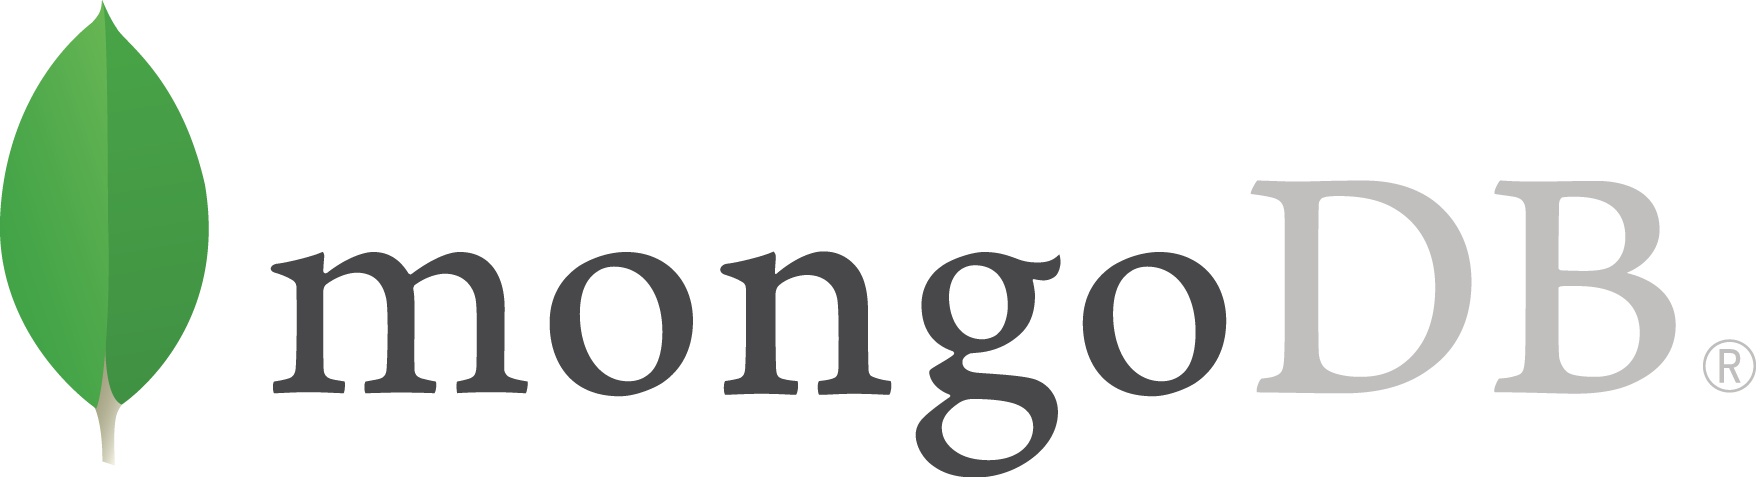

Base de datos documental que usaremos como ejemplo. Una de las más extendidas:

- Modelo de documentos JSON (BSON, en binario, usado para eficiencia)
- Map-Reduce para transformaciones de la base de datos y consultas
- Lenguaje propio de manipulación de la base de datos llamado "de agregación" (aggregate)
- Soporta sharding (distribución de partes de la BD en distintos nodos)
- Soporta replicación (copias sincronizadas master-slave en distintos nodos)
- No soporta ACID
- La transacción se realiza a nivel de **DOCUMENTO**

Usaremos `pymongo` desde Python. Para instalarlo:

    pip install --upgrade pymongo


In [ ]:
%%bash
sudo docker pull mongo

In [ ]:
!pip install pymongo lxml folium ipython-cypher

In [ ]:
!sudo docker run --rm -d --name mongo -p 27017:27017 mongo

In [ ]:
import pymongo
from pymongo import MongoClient
client = MongoClient("localhost", 27017)
client

Creamos una base de datos `centic18`:

In [ ]:
db = client.centic18

Y la colección `productos`:

In [ ]:
productos = db.productos
productos

In [ ]:
productos.insert_one(
    {
        'nombre': 'Samsung XX40',
        'descripción' : 'Televisión Samsung, 40"...',
        'precio' : '600',
        'fabricante': 'Samsung',
        'stock': 20,
        'tags' : ['tv', '40"', 'lcd', 'hdmi', 'smart-tv']
    })

In [ ]:
client.database_names()

In [ ]:
DictTable(productos.find_one())

In [ ]:
productos.insert_one(
    {'nombre': 'LG T42',
     'descripción' : 'Televisión LG 42"',
     'precio' : 655,
     'fabricante': "LG",
     'stock': 10,
     'tags' : ['tv', '42"', 'led', 'hdmi', 'smart-tv']
    })

In [ ]:
list(productos.find({},{"fabricante" : 1, "stock" : 1}))

También quieren guardar las diferentes charlas que hay... Para ello, nada mejor que obtener la lista de charlas desde la propia página web... :)

## Consultas sencillas

Distribución del número de charlas en las que están interesadas los asistentes.

In [ ]:
list(db.productos.find({"stock" : {"$gt" : 10, "$lte" : 30}}))

In [ ]:
list(db.productos.find({ "$or" :
     [ {"fabricante" : "Samsung" }, {"fabricante" : "LG"} ] }))

In [ ]:
list(db.productos.find({"tags" : {"$elemMatch" : {'$in' : ['tv', 'smart-tv']}}}))

La función `find()` tiene un gran número de posibilidades para especificar la búsqueda. Se pueden utilizar cualificadores complejos como:

- `$and`
- `$or`
- `$not`

Estos calificadores unen "objetos", no valores. Por otro lado, hay otros calificadores que se refieren a valores:

- `$lt` (menor)
- `$lte` (menor o igual)
- `$gt` (mayor)
- `$gte` (mayor o igual)
- `$regex` (expresión regular)

¡Queremos añadir las valoraciones de usuarios!

In [ ]:
from bson import ObjectId

In [ ]:
db.productos.update_one({'_id': ObjectId('5b1d09b3b3d977001bc53e03')},
                        {'$push' : {'valoraciones' : {'user': 'Pepe', 'estrellas' : 3.5, 'comment': 'bah'}}})

In [ ]:
db.productos.update_one({'_id': ObjectId('5b1d09b3b3d977001bc53e03')},
                        {'$push' : {'valoraciones' : {'user': 'Diego', 'estrellas' : 5, 'comment': 'Like!'}}})

In [ ]:
list(db.productos.find())

### Map-Reduce

MongoDB incluye dos APIs para procesar y buscar documentos: el API de Map-Reduce y el API de agregación. Veremos primero el de Map-Reduce. Manual: https://docs.mongodb.com/manual/aggregation/#map-reduce



### Media de valoraciones de los usuarios por fabricante

Con Map-Reduce se muestra la media de valoraciones de los usuarios para los productos de un fabricante en concreto.

In [ ]:
from bson.code import Code
map = Code(
    '''function () {
           obj = this
           if ('valoraciones' in this)
               this['valoraciones'].forEach(function (v) {
                   emit(obj.fabricante, v.estrellas);
               })
       }''')
reduce = Code(
    '''function (key, values) {
            return Array.sum(values) / values.length;
        }''')
results = db.productos.map_reduce(map, reduce, "valoración_media")

In [ ]:
results = list(results.find())
results

## Framework de Agregación

Framework de agregación: https://docs.mongodb.com/manual/reference/operator/aggregation/. Y aquí una presentación interesante sobre el tema: https://www.mongodb.com/presentations/aggregation-framework-0?jmp=docs&_ga=1.223708571.1466850754.1477658152



In [ ]:
val_media = db.productos.aggregate( [
        {'$project': {
            'fabricante' : True,
            'valoraciones' : True}
        },
        {'$unwind' : '$valoraciones' },
        {'$group' : {
            '_id' : '$fabricante',
            'avg_val' : {'$avg' : '$valoraciones.estrellas'}
        }},
        {'$sort' : { 'avg_val' : 1}}
        ])

In [ ]:
list(val_media)

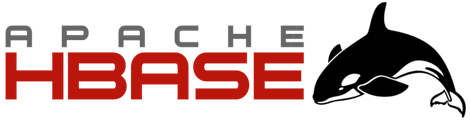

Ahora se muestra cómo acceder a bases de datos HBase y también a conectar la salida con Jupyter.

In [1]:
!pip install happybase

    100% |████████████████████████████████| 40kB 937kB/s ta 0:00:01
    100% |████████████████████████████████| 215kB 1.5MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 2.3MB/s ta 0:00:01
  Running setup.py bdist_wheel for happybase ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/7a/d7/f7/447e781495238e394f04fe169f14549d31c63993e90152693b
  Running setup.py bdist_wheel for thriftpy ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/64/ff/0b/00a7ab5df78f8360908e34744eb78c2c537a327a295da5c260
Successfully built happybase thriftpy
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!sudo curl -L https://github.com/docker/compose/releases/download/1.21.2/docker-compose-$(uname -s)-$(uname -m) -o /usr/bin/docker-compose
!sudo chmod a+x /usr/bin/docker-compose    

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   617    0   617    0     0    995      0 --:--:-- --:--:-- --:--:--   993
100 10.3M  100 10.3M    0     0  2459k      0  0:00:04  0:00:04 --:--:-- 3653k


In [ ]:
%%bash
cd hbase && sudo /usr/bin/docker-compose up

In [11]:
import happybase

host = 'localhost'
connection = happybase.Connection(host)
connection.tables()

[b'productos']

In [8]:
try:
    connection.create_table(
            'productos',
            {
                'd': dict(max_versions=1),
                'val' : dict(max_versions=1,compression='GZ')
            })
except:
    print("Error creando database: productos")
    pass

In [9]:
connection.tables()

[b'productos']

In [12]:
productos = connection.table('productos')
productos.row(b'5',columns=[b'd:Body'])

{}

## Neo4j (Grafos)

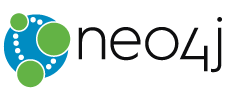

Se puede utilizar el propio interfaz de Neo4j también en la dirección http://127.0.0.1:7474.

In [ ]:
%%bash
sudo docker pull neo4j

In [ ]:
%%bash
sudo docker run -d --rm --name neo4j -p 7474:7474 -p 7687:7687 --env NEO4J_AUTH=none neo4j

Vamos a cargar la extensión `ipython-cypher` para poder lanzar consultas Cypher directamente a través de la hoja. He iniciado la imagen de Neo4j sin autenticación, para pruebas locales.

Utilizaremos una extensión de Jupyter Notebook que se llama `ipython-cypher`. Está instalada en la máquina virtual. Si no, se podría instalar con:

    pip install ipython-cypher
    
Después, todas las celdas que comiencen por `%%cypher` y todas las instrucciones Python que comiencen por `%cypher` se enviarán a Neo4j para su interpretación.

### El lenguaje Cypher


### Ipython-cypher

In [ ]:
%load_ext cypher

In [ ]:
%config CypherMagic.auto_html=False
%config CypherMagic.auto_pandas=True

El lenguaje **Cypher** es el lenguaje de consulta y modificación elegido por Neo4j. Es muy distinto de la mayoría de lenguajes de consulta tradicionales, y casi se podría considerar ASCII-Art...

In [ ]:
PImage.open('images/ch_ascii.png')

Los nodos se identifican con nombres entre paréntesis `(n)`, y las relaciones como flechas simuladas con ASCII:

    (n1)-[:RELACIÓN]->(n2)

In [ ]:
%%cypher
match (n) return n;

Vamos a añadir a los participantes y las charlas. Las conectaremos también por relaciones de interés.

In [ ]:
# Primero las charlas

for charla in charlas18.find():
    nombre_charla = charla['título']
    ponentes = charla['ponentes']
    id = charla['_id']
    %cypher CREATE (n:Charla {id: {id}, título: {nombre_charla}, ponentes: {ponentes}})

In [ ]:
# Ahora los participantes relacionados con las charlas ya creadas

for p in participantes18.find():
    nombre = p['nombre']
    dni = p['dni']
    ciudad = p.get('ciudad','')
    %cypher CREATE (p:Participante {nombre: {nombre}, dni: {dni}, ciudad: {ciudad}})
    for i in p['intereses']:
        %cypher MATCH (c:Charla {id : {i}}), (p:Participante {nombre: {nombre}}) MERGE (p)-[:INTERESADO]->(c)

In [ ]:
#'https://es.wikipedia.org/wiki/Star_Wars'
personajes = pd.read_html("extra/StarWarsWikipedia.html",attrs={'class': 'wikitable'})
personajes = personajes[0]

In [ ]:
personajes.iloc[15:]

In [ ]:
películas = list(personajes.iloc[15])
películas

In [ ]:
for título in películas:
    %cypher CREATE (p:Pelicula {título: {título}})

In [ ]:
import cypher

for p in participantes18.find():
    nombre = p['nombre']
    res = personajes[personajes[0] == nombre]
    if not res.empty:
        for n,app in enumerate(list(res.iloc[0])[1:]):
            if not pd.isnull(app):
                título = películas[n+1]
                print (n,nombre, titulo)
                cypher.run("MATCH (p:Participante {nombre: \"%s\"}), (film:Pelicula {título: \"%s\"}) MERGE (p)-[:STARRING]->(film)"
                           % (nombre, título))

In [ ]:
%config CypherMagic.auto_networkx=False
%config CypherMagic.auto_pandas=False

In [ ]:
%%cypher
MATCH p=shortestPath(
  (hs:Participante {nombre: "Han Solo"})-[*]-(lo:Participante {nombre: "Leia Organa"})
)
RETURN p

In [ ]:
yoda(u'May the force be with you')

In [ ]:
chew('Grrrrrrrrrr!')

In [ ]:
!sudo docker stop neo4j

In [ ]:
!sudo docker stop mongo